In [1]:
using Pkg
Pkg.activate(".")
using OptimalTransport

  Activating new environment at `~/qrot_graph/script/Project.toml`


In [3]:
]add ~/OptimalTransport.jl#symmetric_quad

    Updating git-repo `/home/syz/OptimalTransport.jl`
   Resolving package versions...
    Updating `~/qrot_graph/script/Project.toml`
  [7e02d93a] ~ OptimalTransport v0.3.12 `/home/syz/OptimalTransport.jl#sinkhorn_barycenter` ⇒ v0.3.19 `/home/syz/OptimalTransport.jl#symmetric_quad`
    Updating `~/qrot_graph/script/Manifest.toml`
  [24df6009] + ExactOptimalTransport v0.2.0
  [7e02d93a] ~ OptimalTransport v0.3.12 `/home/syz/OptimalTransport.jl#sinkhorn_barycenter` ⇒ v0.3.19 `/home/syz/OptimalTransport.jl#symmetric_quad`
  [189a3867] + Reexport v1.2.2
Precompiling project...
  ✓ JLLWrappers
  ✓ BenchmarkTools
  ✓ Rmath_jll
  ✓ Bzip2_jll
  ✓ OpenSpecFun_jll
  ✓ CodecBzip2
  ✓ StatsBase
  ✓ Rmath
  ✓ NNlib
  ✓ SpecialFunctions
  ✓ StatsFuns
  ✓ Distributions
  ✓ MathOptInterface
  ✓ ExactOptimalTransport
  ✓ OptimalTransport
  15 dependencies successfully precompiled in 52 seconds (37 already precompiled)
  15 dependencies precompiled but different versions are currently loaded. Restart j

In [4]:
using Distributed, SharedArrays
using LinearAlgebra, SparseArrays, StatsBase, Distances, IterativeSolvers
using NearestNeighbors, OptimalTransport, MultivariateStats
using Distributed, SharedArrays
# include("../src/ssl_utils.jl")
using Plots

using LightGraphs, GraphPlot
# using Cairo, Compose

In [5]:

#Make a spiral with k arms and n points per arm
# PARAM: 
# arms: array of integers, n-th entry is the number of points on n-th arm
# todo: take a function f as input for sscaling along arm
function general_kSpiral(arms; st = 0.5, ed = 5)
    total_so_far = 0
    total_pts = sum(arms)
    class_num = length(arms)
    
    #Divide a full rotation into k intervals
    θ = range(0, 2π, length = class_num+1)
    
    #Make a matrix of labels
    inds = ones(Int32, total_pts) 
    
    X = zeros(total_pts, 2)
    T = zeros(total_pts)


    for i in 1:class_num

        t = ed * rand(arms[i]).^2 .+ st

#         t = ed * LinRange(0, 1, arms[i]).^2 .+ st
        
        sort!(t)
        
        #Plug into the parametrization for the spiral
        x = @. [cos(t) * t sin(t) * t] 

        #Rotate to give spiral effect
        X[total_so_far+1 : total_so_far + arms[i], :] = rotate_point(x', θ[i]) 
        T[total_so_far+1 : total_so_far + arms[i], :] = t

        #Label arm i as i
        inds[total_so_far+1 : total_so_far + arms[i]] .= i 

        total_so_far += arms[i]

    end
    
    return X, T, inds
end


@everywhere function rotate_point(x, θ)
    r = @. [[cos(θ) -sin(θ)]; 
            [sin(θ)  cos(θ)]] 

    return (r*x)'
end




In [6]:

function sample_labels(all_labels, prop)
    N = length(all_labels)
    #Sample nodes for which we assume labels are known
    label_idx = sample(1:N, Int(floor(prop*N)), replace = false) #Get the indices of the nodes
#     sort!(label_idx)
    labels = all_labels[label_idx]  #Get the corresponding labels

    return label_idx, labels
end

function initialize_SSL(label_idx, labels, N, K)
    #Mark selected nodes as true, and all others false (indicator)
    given_labels = zeros(Bool, N) 
    given_labels[label_idx] .= true

    # label selection matrix
    S = sparse(label_idx, label_idx, 1.0, N, N) #A diag matrix with ones on labelled nodes
    P = sparse(label_idx, labels, 1.0, N, K) #A selection matrix where labelled cells are marked in their corresponding color colum
#     Q = rand(N, K) #A likelihood matrix for nodes being in a class
    Q = ones(N, K) #A likelihood matrix for nodes being in a class
    
    return given_labels, S, P, Q
end



function solve_SSL!(γ, Q, P, S, η = 8)
    #Solve the linear system for likelihood
    cg!(Q, S+η*(I-γ), P, maxiter=1000)
#     Q = Matrix(S+η*(I-γ)) \ Matrix(P) .+ 1e-10
    
    return Q
end

function infer_labels(Q)
    _, class_num = size(Q)
    soft_label = Q*collect(1:class_num)
    inferred_label = getindex.( argmax(Q, dims=2), 2)[:]
    
    return soft_label, inferred_label
end

function accuracy(all_labels, label_idx, infer_label, N)
    acc = 1- sum(abs.(labels_all[.!label_idx]-infer_label[.!label_idx]) .>0)/(N-sum(label_idx))

    return acc
end

function predict_label(γ, label_idx, labels, N, K)

    given_labels, S, P, Q = initialize_SSL(label_idx, labels, N, K)
    
    Q = solve_SSL!(γ, Q, P, S)
    
    _, infer_label = infer_labels(Q)    
    
    return Q, infer_label
end


function kNN_Weight(X, k, σ = 0.5)
    
    N = size(X)[1]
    knn_idxs, knn_dists = knn( KDTree(X'), X', k, true)

    # adjacency matrix
    inds = vcat(Int.(ones(k)*collect(1:N)')...)
    A = sparse(inds, vcat(knn_idxs...), 1, N, N)

    inds_sym = A+A'.>0
    K = spzeros(N, N)
#     σ = 0.5
#     TODO: vary \sigma
    C = pairwise(SqEuclidean(), X, X, dims=1)
    K[inds_sym] = exp.(-C[inds_sym].^2 / σ)

    d = spdiagm(0 => sum(K, dims=1)[1, :].^(-1))

    return d*K
end


function QOT_weight(X, ε; maxiter=15, solver="SSN", kwargs...)
    N, class_num = size(X)
    C = pairwise(SqEuclidean(), X, X, dims=1) #Euclidean distance between nodes
#     C[diagind(C)] .= Inf #No self edges allowed
    
    if solver == "SSN"
        return quadreg(ones(N), ones(N), C, ε, maxiter=maxiter)
    elseif solver == "LBFGS"
        return PythonOT.pot.smooth.smooth_ot_dual(ones(N), ones(N), C, ε;  kwargs...)
    else
        return
    end
end

function ENT_weight(X, ε)
    N, class_num = size(X)
    C = pairwise(SqEuclidean(), X, X, dims=1) #Euclidean distance between nodes
    C[diagind(C)] .= Inf #No self edges allowed
    
    return sinkhorn(ones(N), ones(N), C, ε)
end


ENT_weight (generic function with 1 method)

┌ Info: Entropy = -0.0
└ @ Main In[7]:7
┌ Info: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
└ @ Main In[7]:8


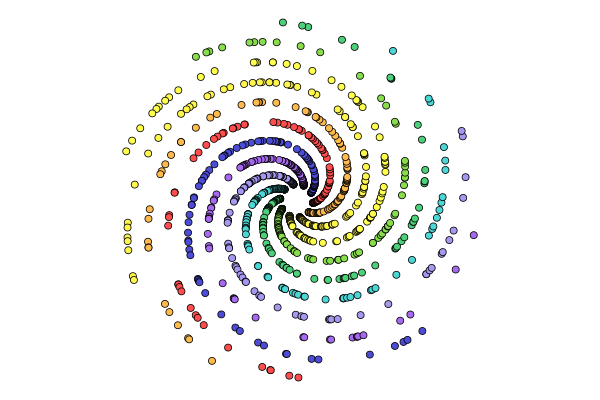

In [7]:
using Random
using Distributions
using LogExpFunctions
# arms = [1,1,1,1,1,5,5,5,5,5]
# arms = [1,5,1,5,1,5,1,5,1,5]
arms = ones(10)
@info "Entropy = $(-sum(xlogx.(arms)))"
@info arms
N = 1000
arms =  Int.(round.(arms./sum(arms) * N))
N = sum(arms)
K = length(arms)

X, T, labels_all = general_kSpiral(arms)

scatter(X[:, 1], X[:, 2], marker_z = labels_all, c = :lighttest, 
    ticks = nothing, leg=false,  grid=false, showaxis = false, aspect_ratio=1.0)
# savefig("../figs/spiral_data")

In [8]:
N

1000

In [9]:
using StatsBase

prop = 0.1

label_idx, labels = sample_labels( labels_all, prop)

ε = 1.0
γ_qot = QOT_weight(X, ε)

Q_qot, infer_label = predict_label(γ_qot, label_idx, labels, N, K)

([0.9978568768780154 0.0012259404080948982 … 2.2603222715993675e-5 0.00018234528749971684; 0.9978552811571285 0.0012268531919857916 … 2.2620028137681845e-5 0.00018248103215834211; … ; 6.243966104254342e-5 0.0009126280845330044 … 2.8158128191945845e-7 0.9448623160236517; 5.988900075164283e-5 0.0008753533479359607 … 2.697667071294613e-7 0.943065179775421], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

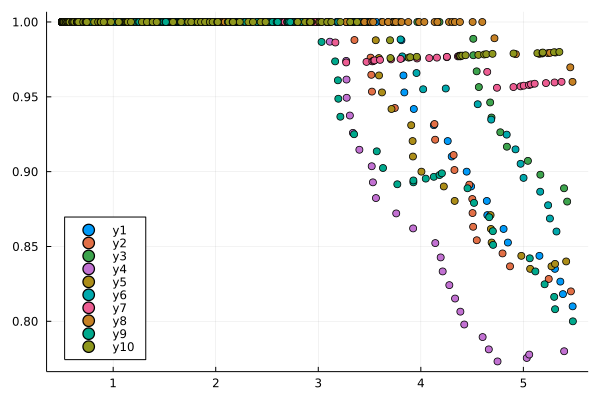

In [10]:
fig = plot()

for arm in 1:10

    infered_arm = infer_label[labels_all .== arm]
    n = length(infered_arm)
    y = zeros(n)

    for k in 1:n
        y[k] = sum(infered_arm[1:k] .== labels_all[labels_all .== arm][1:k]) / k
    end

    scatter!(T[labels_all .== arm], y, legend = :bottomleft)
end
display(fig)
# savefig("../figs/QOT_t_vs_acc")

In [11]:
c = distinguishable_colors(10, colorant"yellow")
# print(infer_label)
c[infer_label]


In [12]:
c[labels_all]

In [13]:
sum(labels_all .== infer_label) /N

0.869

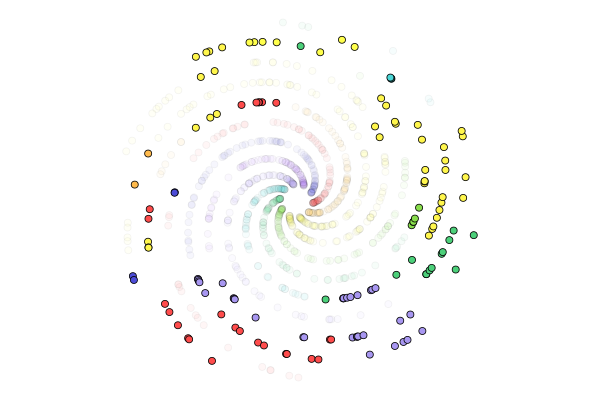

In [14]:
inds = infer_label .!= labels_all
r = 1:N
mislabel_qot = r[inds]


hd = scatter(X[:, 1], X[:, 2], marker_z = infer_label, alpha=0.05, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

scatter!(X[mislabel_qot, 1], X[mislabel_qot, 2], marker_z = infer_label[mislabel_qot], alpha=1.00, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

# savefig("../figures/Varying_density_spiral/QOT_infered925")
display(hd)


In [15]:

k = 5
γ_knn = kNN_Weight(X, k)

Q_knn, infer_label_knn = predict_label(γ_knn, label_idx, labels, N, K)

([0.9980297403371478 2.490853768550382e-5 … 0.0003214296065568752 0.0011373008388170886; 0.9980297403368072 2.4908537689858826e-5 … 0.000321429606612638 0.0011373008390142929; … ; 0.00237032470102237 0.03524534991027097 … 0.0009982103124348536 0.6542706541524794; 0.0021980671941821328 0.0326504469121446 … 0.0009648636307148975 0.6412754275078313], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

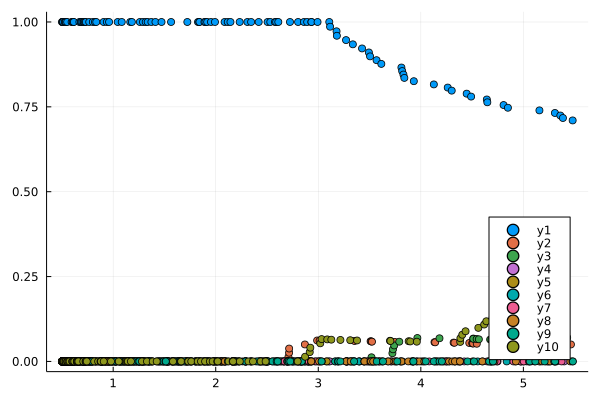

In [16]:
fig = plot()

for arm in 1:10

    infered_arm = infer_label_knn[labels_all .== arm]
    n = length(infered_arm)
    y = zeros(n)

    for k in 1:n
        y[k] = sum(infer_label_knn[1:k] .== labels_all[labels_all .== arm][1:k]) / k
    end

    scatter!(T[labels_all .== arm], y, legend = :bottomright)
end
display(fig)
# savefig("../figures/Varying_density_spiral/KNN_t_vs_acc")

In [17]:
c[labels_all]

In [18]:
c[infer_label_knn]

In [19]:
sum(labels_all .== infer_label_knn) /N

0.776

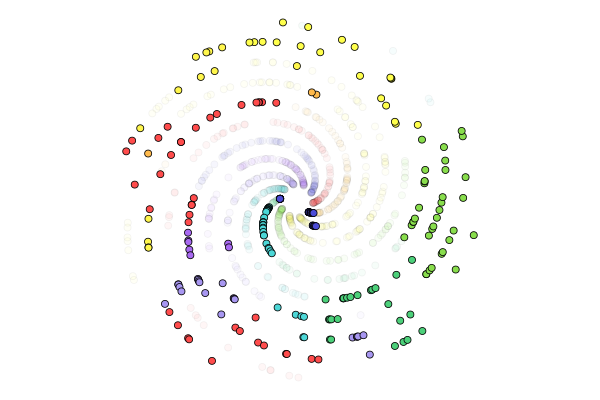

In [20]:
inds_knn = infer_label_knn .!= labels_all
r = 1:N
mislabel_knn = r[inds_knn]



hd = scatter(X[:, 1], X[:, 2], marker_z = infer_label_knn, alpha=0.05, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)

scatter!(X[mislabel_knn, 1], X[mislabel_knn, 2], marker_z = infer_label_knn[mislabel_knn], alpha=1.00, 
    c = :lighttest, ticks = nothing, leg=false, showaxis=false, aspect_ratio=1.0)


display(hd)

# ew = makeEdgeWeights(γ_knn)

# G = LightGraphs.Graph(γ_knn+γ_knn')
# # gp_ew = gplot(G, X[:,1], -X[:,2], edgelinewidth=ew)
# gp = gplot(G, X[:,1], -X[:,2])

# # draw(PNG("../figures/Varying_density_spiral/QOT_graph.png", 16cm, 16cm), gp)

# display(gp)
# display(gp_ew)

In [23]:
Le = length(eps_val)
Lk = length(knn_val)

QOT_acc = zeros(5, Le)
KNN_acc = zeros(5, Lk)

param_num = 11
eps_val = exp10.(-1:0.1:1)
knn_val = 3:18

for i in 1:5
arms = ones(10)
@info "Entropy = $(-sum(xlogx.(arms)))"
@info arms
N = 1000 * i
arms =  Int.(round.(arms./sum(arms) * N))
N = sum(arms)
K = length(arms)

X, T, labels_all = general_kSpiral(arms)
prop = 0.1
label_idx, labels = sample_labels( labels_all, prop)

for j in 1:Le
    ε = eps_val[j]
    γ_qot = QOT_weight(X, ε)
    Q_qot, infer_label = predict_label(γ_qot, label_idx, labels, N, K)
    QOT_acc[i, j] = sum(labels_all .== infer_label) /N
end
for j in 1:Lk
    k = knn_val[j]
    γ_knn = kNN_Weight(X, k, 1.0)
    Q_knn, infer_label_knn = predict_label(γ_knn, label_idx, labels, N, K)
    KNN_acc[i, j] = sum(labels_all .== infer_label_knn) /N
end
    
end

LoadError: UndefVarError: eps_val not defined

In [ ]:
QOT_acc

In [ ]:
plot(log10.(eps_val), QOT_acc[1, :], ylims=(0.4, 1.1),
    label="100", title="QOT: ε vs accuracy", legend=:bottomleft)
plot!(log10.(eps_val), QOT_acc[2, :], label="200")
plot!(log10.(eps_val), QOT_acc[3, :], label="300")
plot!(log10.(eps_val), QOT_acc[4, :], label="400")
plot!(log10.(eps_val), QOT_acc[5, :], label="500")



In [ ]:
plot(knn_val, KNN_acc[1, :], ylims=(0.4, 1.1),
    label="100", title="kNN: k vs accuracy", legend=:bottomleft)
plot!(knn_val, KNN_acc[2, :], label="200")
plot!(knn_val, KNN_acc[3, :], label="300")
plot!(knn_val, KNN_acc[4, :], label="400")
plot!(knn_val, KNN_acc[5, :], label="500")

In [ ]:
exp10.(-1:0.2:1)
collect(2:12)

In [25]:
sample_num = 10
param_num = 11
prop = 0.01

Entropy = zeros(sample_num)

eps_val = exp10.(-1:0.2:1)
knn_val = 4:14

QOT_acc = SharedArray{Float64}(sample_num, param_num)
KNN_acc = SharedArray{Float64}(sample_num, param_num)

@time for i in 1:sample_num
    N = 1000
    arms = rand(Dirichlet(ones(10)))
    Entropy[i] = -sum(xlogx.(arms))
    
    arms =  Int.(round.(arms./sum(arms) * N))
    N = sum(arms)
    K = length(arms)

    X, T, labels_all = general_kSpiral(arms)
    label_idx, labels = sample_labels( labels_all, prop)

    for j in 1:param_num
        ε = eps_val[j]
        γ_qot = QOT_weight(X, ε)
        Q_qot, infer_label = predict_label(γ_qot, label_idx, labels, N, K)
        QOT_acc[i, j] = sum(labels_all .== infer_label) /N

        k = knn_val[j]
        γ_knn = kNN_Weight(X, k, 1.0)
        Q_knn, infer_label_knn = predict_label(γ_knn, label_idx, labels, N, K)
        KNN_acc[i, j] = sum(labels_all .== infer_label_knn) /N
    end
end

┌ Warning: Semi-smooth Newton algorithm (15/15): not converged
└ @ OptimalTransport /home/syz/.julia/packages/OptimalTransport/3NAIg/src/quadratic_newton.jl:216
┌ Warning: Semi-smooth Newton algorithm (15/15): not converged
└ @ OptimalTransport /home/syz/.julia/packages/OptimalTransport/3NAIg/src/quadratic_newton.jl:216
┌ Warning: Semi-smooth Newton algorithm (15/15): not converged
└ @ OptimalTransport /home/syz/.julia/packages/OptimalTransport/3NAIg/src/quadratic_newton.jl:216
┌ Warning: Semi-smooth Newton algorithm (15/15): not converged
└ @ OptimalTransport /home/syz/.julia/packages/OptimalTransport/3NAIg/src/quadratic_newton.jl:216
┌ Warning: Semi-smooth Newton algorithm (15/15): not converged
└ @ OptimalTransport /home/syz/.julia/packages/OptimalTransport/3NAIg/src/quadratic_newton.jl:216
┌ Warning: Semi-smooth Newton algorithm (15/15): not converged
└ @ OptimalTransport /home/syz/.julia/packages/OptimalTransport/3NAIg/src/quadratic_newton.jl:216
┌ Warning: Semi-smooth Newton algo

336.734044 seconds (907.89 k allocations: 133.941 GiB, 5.21% gc time, 0.02% compilation time)


In [ ]:
p = sortperm(Entropy)




In [ ]:
ht = heatmap(Entropy[p], log10.(eps_val), QOT_acc[p,:]', clim=(0.0, 1.0),
        ylabel= "log(ϵ)", xlabel="Entropy", title="QOT Accuracy")

In [ ]:
ht = heatmap(Entropy[p], knn_val, KNN_acc[p,:]', clim=(0.0, 1.0),
        ylabel= "neighbours", xlabel="Entropy", title="KNN Accuracy")